In [216]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import optuna
import joblib
from statistics import mean 

import torch

from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel, LightGBMModel, \
                        CatBoostModel, XGBModel,  BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel

from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

from statsmodels.tsa.statespace.sarimax import SARIMAX


from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [217]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [218]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
          'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh']
cities = [ 'Bình Phước', 'An Giang','Quảng Ninh']

In [219]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [220]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [221]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [222]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [223]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Dengue fever rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Dengue_fever_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [224]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [225]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [226]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [227]:
def train_and_evaluate(df_full, model_name, location, feature_list, labels, scaler, cfg):
    """
    $df: pandas.DataFrame object containing data for training and testing model:
    $model: darts model object
    $feature_list: Names of the features used as model input
    $label: the value the model will be trained to predict
    $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
    $lags: how much to look back into the past to output prediction
    $split_index: the point at which to divide train and test_data

    """
    order, sorder, trend = cfg
    trainlist = [x for x in df_full.Dengue_fever_rates]
    nstep = args.n_predicted_period_months

    if(model_name == "SARIMA"):
        predict_list = []
        for i in range (args.test_size+(nstep-1)):
            history = trainlist[:-args.test_size-(nstep-1-i)]
            model = SARIMAX(history, 
                            order=order, 
                            seasonal_order=sorder, 
                            trend = trend,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            yhat = model_fit.predict(len(history), len(history) + nstep - 1)
            predict_list.append(yhat)
    y_pred_list = []
    for step in range(nstep):
        moving = nstep-1-step
        y_pred_list.append([x[step] for x in predict_list][moving:args.test_size+moving])

    df_eval_true_inverse = df_full[-args.test_size:]
    y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)

    y_pred_inverse_list = []
    for step in range(nstep):
        df_eval_pred_inverse = df_full[-args.test_size:]
        df_eval_pred_inverse[args.labels]= y_pred_list[step] #step 1
        y_pred_inverse = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
        y_pred_inverse_list.append(y_pred_inverse)

    y_pred_inverse_list
    df_compare_test_predict = pd.DataFrame({
        'y_true':y_true,
        'y_pred_1step':y_pred_inverse_list[0],
        'y_pred_2step':y_pred_inverse_list[1],
        'y_pred_3step':y_pred_inverse_list[2],
        'y_pred_4step':y_pred_inverse_list[3],
        'y_pred_5step':y_pred_inverse_list[4],
        'y_pred_6step':y_pred_inverse_list[5],
        })
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()
    mse_nstep = []
    mae_nstep = []
    rmse_nstep = []
    mape_nstep = []
    for step in range(nstep):
        mse_nstep.append(mean_squared_error(y_true, y_pred_inverse_list[step]))
        mae_nstep.append(mean_absolute_error(y_true, y_pred_inverse_list[step]))
        rmse_nstep.append(mse_nstep[step]**0.5)
        mape_nstep.append(mean_absolute_percentage_error(y_true, y_pred_inverse_list[step]))
    return model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep


In [228]:
def output_prediction_for_location(df_full, model_name, location, feature_list, 
                                                labels, scaler, cfg):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep = train_and_evaluate(df_full, model_name, location, feature_list, labels, scaler, cfg)
    
    df_prediction = pd.DataFrame({"Date": df_full["year_month"][-args.test_size:],
                                  "Observed": y_true[-args.test_size:],
                                  f"{1}-month": y_pred_inverse_list[0],
                                  f"{2}-month": y_pred_inverse_list[1],
                                  f"{3}-month": y_pred_inverse_list[2],
                                  f"{4}-month": y_pred_inverse_list[3],
                                  f"{5}-month": y_pred_inverse_list[4],
                                  f"{6}-month": y_pred_inverse_list[5]})
    
    df_prediction["City"] = location
    for step in range(args.n_predicted_period_months):
        df_prediction[f"RMSE_{step+1}-month"] = rmse_nstep[step]
        df_prediction[f"MAE_{step+1}-month"] = mae_nstep[step]
        df_prediction[f"MAPE_{step+1}-month"] = mape_nstep[step]
        df_prediction[f"MSE_{step+1}-month"] = mse_nstep[step]
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️")
    display(df_prediction.head(5))
    print(mean(mae_nstep))
    return mean(mae_nstep)

In [229]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

# Objective and Suggest Hyperparams of Darts Models


In [230]:
def objective(model_name, trial, city):   
    specific_data = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
    scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
    # df_train, df_valid = split_data(specific_data, args.look_back,nstep)

    selected_features = getDataWithSelectedFeature(city, 6)

    # lags_by_nstep = args.look_back + nstep - 1
    # lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3
    # is_dl_algo = 0
    # is_sklearn_model = 0

    if model_name == "SARIMA":
      p = trial.suggest_int('p', 0, 5)
      d = trial.suggest_int('d', 0, 1)
      q = trial.suggest_int('q', 0, 5)
      t = trial.suggest_categorical('t', ['n', 'c', 't', 'ct'])
      P = trial.suggest_int('P', 0, 6)
      D = trial.suggest_int('D', 0, 1)
      Q = trial.suggest_int('Q', 0, 6)
      m = trial.suggest_categorical('m', [6, 12])
      cfg = [(p, d, q), (P, D, Q, m), t]

    # elif model_name == 'SARIMAX':
    #   p = trial.suggest_int('p', 0, 5)
    #   d = trial.suggest_int('d', 0, 1)
    #   q = trial.suggest_int('q', 0, 5)
    #   t = trial.suggest_categorical('t', ['n', 'c', 't', 'ct'])
    #   P = trial.suggest_int('P', 0, 6)
    #   D = trial.suggest_int('D', 0, 1)
    #   Q = trial.suggest_int('Q', 0, 6)
    #   m = trial.suggest_categorical('m', [6, 12])

    #   cfg = [(p, d, q), (P, D, Q, m), t]
    
    mae_error = output_prediction_for_location(specific_data, model_name, location=city, feature_list=selected_features,
                                                labels=args.labels, scaler=scaler,cfg = cfg)

    return mae_error

# Main run optimize and save

[I 2023-10-30 12:27:24,042] A new study created in memory with name: SARIMA


⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name:  SARIMA
⭐️⭐️ City:  Bình Phước


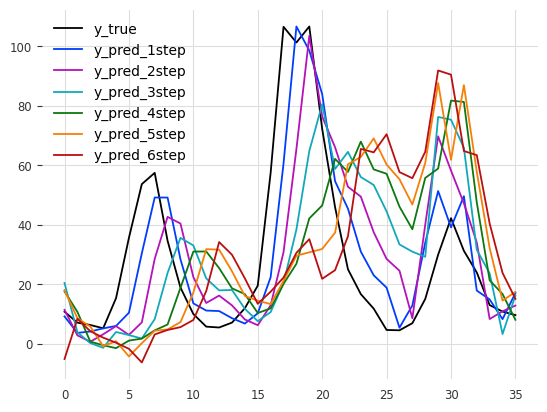

⭐️⭐️⭐️⭐️⭐️⭐️⭐️


,Date,Observed,1-month,2-month,3-month,4-month,5-month,6-month,City,RMSE_1-month,...,MAPE_4-month,MSE_4-month,RMSE_5-month,MAE_5-month,MAPE_5-month,MSE_5-month,RMSE_6-month,MAE_6-month,MAPE_6-month,MSE_6-month
167,2011-01-31,10.810211,9.226633,11.436529,20.489551,17.656540,18.095591,-5.088908,Bình Phước,14.667551,...,1.829193,1344.504164,39.662879,32.16849,2.03603,1573.143942,40.832549,33.641539,2.158684,1667.297067
168,2011-02-28,7.132503,3.693431,2.859628,3.871854,10.754185,8.611129,8.446007,Bình Phước,14.667551,...,1.829193,1344.504164,39.662879,32.16849,2.03603,1573.143942,40.832549,33.641539,2.158684,1667.297067
169,2011-03-31,6.352378,4.158575,0.724219,0.266073,0.756979,5.835343,4.249646,Bình Phước,14.667551,...,1.829193,1344.504164,39.662879,32.16849,2.03603,1573.143942,40.832549,33.641539,2.158684,1667.297067
170,2011-04-30,5.237939,5.204456,3.209385,-1.316584,-0.473664,-0.776936,2.089719,Bình Phước,14.667551,...,1.829193,1344.504164,39.662879,32.16849,2.03603,1573.143942,40.832549,33.641539,2.158684,1667.297067
171,2011-05-31,15.379464,6.032521,5.975691,3.993220,-1.442339,0.910310,0.387733,Bình Phước,14.667551,...,1.829193,1344.504164,39.662879,32.16849,2.03603,1573.143942,40.832549,33.641539,2.158684,1667.297067


[I 2023-10-30 12:28:31,646] Trial 0 finished with value: 24.883548170585364 and parameters: {'p': 1, 'd': 1, 'q': 4, 't': 't', 'P': 4, 'D': 1, 'Q': 3, 'm': 6}. Best is trial 0 with value: 24.883548170585364.


24.883548170585364
Study statistics for : 
  Number of finished trials:  1
Best trial of city:  Bình Phước
🌈🌈🌈🌈🌈
{'p': 1, 'd': 1, 'q': 4, 't': 't', 'P': 4, 'D': 1, 'Q': 3, 'm': 6}
🍓: 1
🍓: 1
🔥🔥🔥🔥🔥🔥


,City,Alg_name,Best_value,n_try_opt,p,d,q,t,P,D,Q,m
0,Bình Phước,SARIMA,24.883548,1,1,1,4,t,4,1,3,6


[I 2023-10-30 12:28:31,726] A new study created in memory with name: SARIMA


🐹
⭐️⭐️ City:  An Giang


[W 2023-10-30 22:39:18,939] Trial 0 failed with parameters: {'p': 0, 'd': 1, 'q': 0, 't': 'n', 'P': 6, 'D': 0, 'Q': 6, 'm': 12} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/trinhtruc/Library/Python/3.9/lib/python/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_91375/711090237.py", line 34, in <lambda>
    obj_func = lambda trial: objective(model_name, trial, cities[city_index])
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_91375/726751381.py", line 36, in objective
    mae_error = output_prediction_for_location(specific_data, model_name, location=city, feature_list=selected_features,
  File "/var/folders/r_/lbw3rw192wl9sx9vtc1c2_xc0000gn/T/ipykernel_91375/1746125129.py", line 12, in output_prediction_for_location
    model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_

KeyboardInterrupt: 

In [231]:
#########################
# Main cell for optimize ML algorithm
#########################
# Hai thuật toán này chưa chạy đc nhe, nên đừng truyền vô mảng để nó chạy nhoé!
# "PoissonRegressor"
# "SVMRBF"
model_name_list = [
    "SARIMA"
    #  "RandomForest",
    #  "LinearRegressionModel",
    #  "LightGBMModel",
    #  "CatBoostModel",
    #  "XGBModel",
    # "SVMRBF",
    # "PoissonRegressor"
    
]


# Lưu thông tin traceback study và error city trong quá trình optimize
l_study_city ={}
l_errCity =[]

if __name__ == '__main__':
  for model_name in model_name_list: 
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️ Model_name: ",model_name)
    best_param = pd.DataFrame()
    for city_index in range(len(cities)):
      print("⭐️⭐️ City: ",cities[city_index])
      # Use Tree-structured Parzen Estimator sampler to minimise RMSE
      sampler = optuna.samplers.TPESampler()
      study = optuna.create_study(sampler=sampler, direction='minimize', study_name = model_name)
      # truyền multiple param vào trong biến trial
      obj_func = lambda trial: objective(model_name, trial, cities[city_index])
      try:
        # Optimise over 100 trials
        study.optimize(obj_func, n_trials=args.ntry, n_jobs=args.njob)

        # Print results
        print("Study statistics for : ")
        print("  Number of finished trials: ", len(study.trials))
        print("Best trial of city: ",cities[city_index])

        best_trial = study.best_trial
        print("🌈🌈🌈🌈🌈")
        print(best_trial.params)
        print("🍓:",best_trial.params['p'])
        print("🍓:",best_trial.params['p'])
        # lưu best param vào trong biến toàn cục

        if model_name == "SARIMA":
            one_city_param = pd.DataFrame({
                              'City':  [cities[city_index]],
                              'Alg_name': 'SARIMA',
                              'Best_value': best_trial.value,
                              'n_try_opt': args.ntry,
                              'p':best_trial.params['p'],
                              'd':best_trial.params['d'],
                              'q':best_trial.params['q'],
                              't':best_trial.params['t'],
                              'P':best_trial.params['P'],
                              'D':best_trial.params['D'],
                              'Q':best_trial.params['Q'],
                              'm':best_trial.params['m']
                          })
            print("🔥🔥🔥🔥🔥🔥")
            display(one_city_param)
        folder_path = f'opt_results/opt_res_ml_26102023/{model_name}/'
        file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_multi-nstep.xlsx'
        if(os.path.isfile(file_path)):
            print("🐸")
            with pd.ExcelWriter(file_path,mode="a",engine="openpyxl",if_sheet_exists="overlay") as writer:
                one_city_param.to_excel(writer, header=None, startrow=city_index+1,index=False)
        else:
            print("🐹")
            if(not (os.path.isdir(folder_path))):
              os.mkdir(folder_path)
            with pd.ExcelWriter(file_path,engine="openpyxl") as writer:
                one_city_param.to_excel(writer, startrow=city_index,index=False)
      except Exception as e:# có error thì lưu vào l_errCity để check lại sau 
        l_errCity.append(cities[city_index])
        print("VÃI Ò CÓ LỖI!!!")
        print(e)
        # send_to_telegram("TEST ARIMA error!" )
        # send_to_telegram(f'Tỉnh bị lỗi trong quá trình optimize bằng model {model_name}: {cities[city_index]}')

In [ ]:
# send_to_telegram("TEST ARIMA done!" )